# Define "Churn" & Goal

Customer churn occurs when customers or subscribers stop doing business with a company or service.
But different industries have different churn definition. Take credit card in financial industry for example, churn can be defined as those customers with no purchases for the last 12 months. and there are several signs that precede customer churns:
1. Usage is declining
2. No usage at all

Therefore, in order to extend my research, I assume that the dataset is from credit card transaction record. And our goal is predict what kind of customers are at risk of churning.


# Data Acquisition and Data Transformation

In [1]:
import csv
import seaborn as sns
import numpy as np
from matplotlib import pyplot  as plt
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
from sklearn.model_selection import GridSearchCV # for tunnig hyper parameter it will use all combination of given parameters
from sklearn.metrics import average_precision_score

In [2]:

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [3]:

counts = pd.read_csv('counts.csv')
spend = pd.read_csv('spend.csv')


In [4]:
counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934028 entries, 0 to 1934027
Data columns (total 3 columns):
account    object
date       object
count      int64
dtypes: int64(1), object(2)
memory usage: 44.3+ MB


In [5]:
spend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934135 entries, 0 to 1934134
Data columns (total 3 columns):
account    object
date       int64
amount     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 44.3+ MB


In [6]:
spend['date'] = pd.to_datetime(spend['date'],unit='s')
counts['date'] = pd.to_datetime(counts['date'])

In [7]:
# inner join
data_merge=pd.merge(spend, counts, on=['account', 'date'])
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1934025 entries, 0 to 1934024
Data columns (total 4 columns):
account    object
date       datetime64[ns]
amount     float64
count      int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 73.8+ MB


Only 1934924 transaction record match between counts and spend dataset.

# Exploratory Data Analysis 

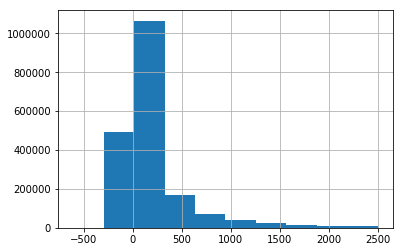

In [8]:
data_merge[data_merge['amount']<2500]['amount'].hist()

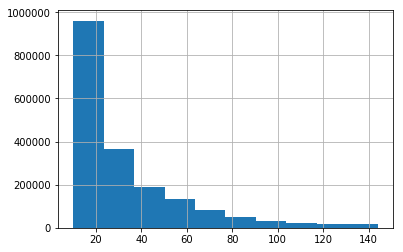

In [107]:
data_merge[data_merge['count']<150]['count'].hist()


Based on two histogram showing above, the majority of transaction amount is below \$500, and the majority of transaction count is below 40. Based on the daily transactions, we could see that the cash flow are very active.

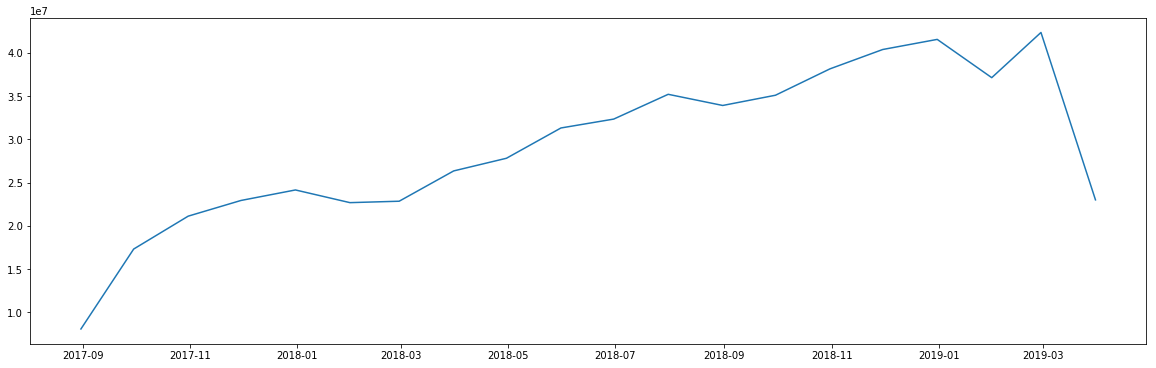

In [17]:
data_time=data_merge.set_index('date')
data_month=data_time.resample('M').sum()
plt.figure(figsize=(20,6))
plt.plot(data_month['amount'])



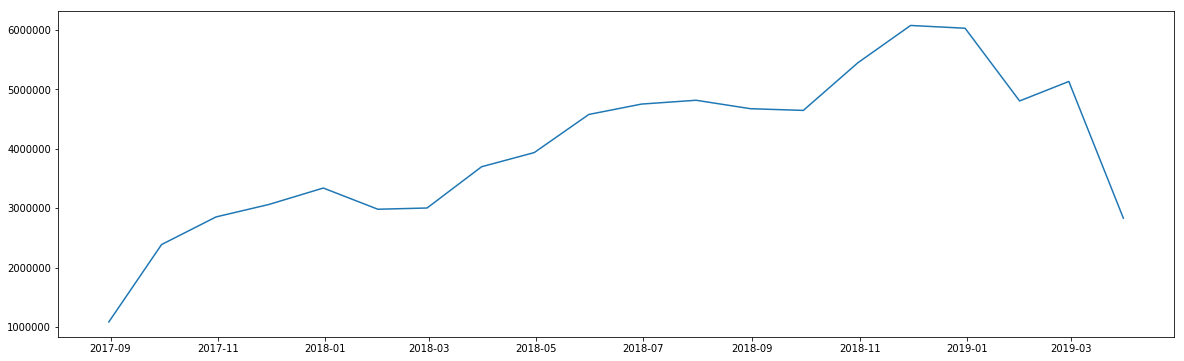

In [19]:
plt.figure(figsize=(20,6))
plt.plot(data_month['count'])

Based on time series from count and amount, although the trend is increasing, but you can observe the seasonality inside the trend.

In [108]:
account_agg=data_merge.groupby('account').sum().reset_index()
account_agg=account_agg.rename(columns = {'count':'total_count','amount':'total_amount'})

#  Feature Engineering

Becasue it's credit card dataset, it might be highly influenced by seasonality, we can aggregate amount and count based on each season per year.
In addition, to define the theshold of churning, we need to create monthly usage feature

## Aggregate month

In [109]:
data_merge['date'] = pd.to_datetime(data_merge['date'])
data_time=data_merge.set_index('date')
data_time.index=data_time.index.strftime('%Y-%m')
data_time.index.name='date'

In [110]:
data_agg_month=data_time.groupby(['date','account']).count().reset_index()

data_agg_month['month_count']=1

data_agg_month['date'] = pd.to_datetime(data_agg_month['date'])
data_agg_month=data_agg_month.set_index('date')

account_agg=account_agg.join(data_agg_month['2017'].groupby('account').count()[['month_count']], on='account')
account_agg=account_agg.rename(columns = {'month_count':'2017_month_count'})

account_agg=account_agg.join(data_agg_month['2018'].groupby('account').count()[['month_count']], on='account')
account_agg=account_agg.rename(columns = {'month_count':'2018_month_count'})

account_agg=account_agg.join(data_agg_month['2019'].groupby('account').count()[['month_count']], on='account')
account_agg=account_agg.rename(columns = {'month_count':'2019_month_count'})

## Aggregate Season

In [111]:
data_agg_season=data_time.groupby(['date','account']).sum().reset_index()

data_agg_season.loc[(data_agg_season['date']=='2017-08'),'date']='2017-Summer'
data_agg_season.loc[(data_agg_season['date']=='2017-09')|(data_agg_season['date']=='2017-10')|(data_agg_season['date']=='2017-11'),'date']='2017-Fall'
data_agg_season.loc[(data_agg_season['date']=='2017-12')|(data_agg_season['date']=='2018-01')|(data_agg_season['date']=='2018-02'),'date']='2017-Winter'

data_agg_season.loc[(data_agg_season['date']=='2018-03')|(data_agg_season['date']=='2018-04')|(data_agg_season['date']=='2018-05'),'date']='2018-Spring'
data_agg_season.loc[(data_agg_season['date']=='2018-06')|(data_agg_season['date']=='2018-07')|(data_agg_season['date']=='2018-08'),'date']='2018-Summer'
data_agg_season.loc[(data_agg_season['date']=='2018-09')|(data_agg_season['date']=='2018-10')|(data_agg_season['date']=='2018-11'),'date']='2018-Fall'
data_agg_season.loc[(data_agg_season['date']=='2018-12')|(data_agg_season['date']=='2019-01')|(data_agg_season['date']=='2019-02'),'date']='2018-Winter'

data_agg_season.loc[(data_agg_season['date']=='2019-03'),'date']='2019-Spring'

In [112]:

account_agg=account_agg.join(data_agg_season[data_agg_season['date']=='2017-Summer'].groupby('account').sum(), on='account')
account_agg=account_agg.rename(columns = {'amount':'2017-Summer-amount','count':'2017-Summer-count'})
account_agg=account_agg.join(data_agg_season[data_agg_season['date']=='2017-Fall'].groupby('account').sum(), on='account')
account_agg=account_agg.rename(columns = {'amount':'2017-Fall-amount','count':'2017-Fall-count'})
account_agg=account_agg.join(data_agg_season[data_agg_season['date']=='2017-Winter'].groupby('account').sum(), on='account')
account_agg=account_agg.rename(columns = {'amount':'2017-Winter-amount','count':'2017-Winter-count'})

account_agg=account_agg.join(data_agg_season[data_agg_season['date']=='2018-Spring'].groupby('account').sum(), on='account')
account_agg=account_agg.rename(columns = {'amount':'2018-Spring-amount','count':'2018-Spring-count'})
account_agg=account_agg.join(data_agg_season[data_agg_season['date']=='2018-Summer'].groupby('account').sum(), on='account')
account_agg=account_agg.rename(columns = {'amount':'2018-Summer-amount','count':'2018-Summer-count'})
account_agg=account_agg.join(data_agg_season[data_agg_season['date']=='2018-Fall'].groupby('account').sum(), on='account')
account_agg=account_agg.rename(columns = {'amount':'2018-Fall-amount','count':'2018-Fall-count'})
account_agg=account_agg.join(data_agg_season[data_agg_season['date']=='2018-Winter'].groupby('account').sum(), on='account')
account_agg=account_agg.rename(columns = {'amount':'2018-Winter-amount','count':'2018-Winter-count'})

account_agg=account_agg.join(data_agg_season[data_agg_season['date']=='2019-Spring'].groupby('account').sum(), on='account')
account_agg=account_agg.rename(columns = {'amount':'2019-Spring-amount','count':'2019-Spring-count'})

In [113]:
#Average each season (only 2017-summer and 2019-spring have 1 month, others have full three months)
account_agg.iloc[:,8:20] = account_agg.iloc[:,8:20]/3

### Fill null value 

In [114]:
account_agg=account_agg.fillna(0)
data_combine=account_agg.drop(['total_amount', 'total_count'], axis=1)

## Data Label Definition 

Becasue this is credit card dataset, we can define the threshold for churning as customer who doesn't have any transaction over a 12 month period in 2017-2019, then they would be labeled as churning, otherwise not.


In [115]:
data_combine['label']=-1

# data_combine.loc[(data_combine['2018_month_count']<6), 'label'] = 1
# data_combine.loc[(data_combine['2018_month_count']>=6)&(data_combine['2017_total_count']==0)&(data_combine['2019_total_count']==0), 'label'] = 1

data_combine['month_usage']=data_combine['2018_month_count']+data_combine['2019_month_count']
data_combine['month_usage']=data_combine['month_usage']+data_combine['2017_month_count']
data_combine.loc[(data_combine['month_usage']<=8)&(data_combine['label']==-1), 'label'] = 1

data_combine.loc[(data_combine['label']==-1),'label']=0

In [116]:
data_combine.groupby('label').count()[['account']]

,account
label,
0,8151
1,1848


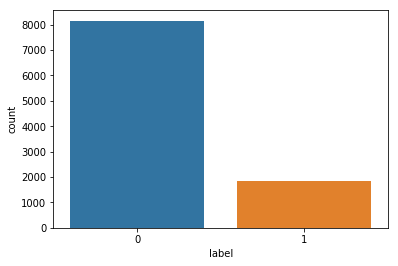

In [117]:
sns.countplot("label",data=data_combine)

After defining the threshold, the total number of churn customer accounts for only 18%. So it's a slightly imbalanced data. In order to solve the issue, we can run a resampling technique, SMOTE, which would help us create synthetic data point for minority group later.

In [118]:
data_combine=data_combine.drop(['month_usage','2018_month_count','2019_month_count','2017_month_count'], axis=1)
data_combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 18 columns):
account               9999 non-null object
2017-Summer-amount    9999 non-null float64
2017-Summer-count     9999 non-null float64
2017-Fall-amount      9999 non-null float64
2017-Fall-count       9999 non-null float64
2017-Winter-amount    9999 non-null float64
2017-Winter-count     9999 non-null float64
2018-Spring-amount    9999 non-null float64
2018-Spring-count     9999 non-null float64
2018-Summer-amount    9999 non-null float64
2018-Summer-count     9999 non-null float64
2018-Fall-amount      9999 non-null float64
2018-Fall-count       9999 non-null float64
2018-Winter-amount    9999 non-null float64
2018-Winter-count     9999 non-null float64
2019-Spring-amount    9999 non-null float64
2019-Spring-count     9999 non-null float64
label                 9999 non-null int64
dtypes: float64(16), int64(1), object(1)
memory usage: 1.4+ MB


In [119]:
df_account=data_combine[['account']]

In [120]:
data_combine=data_combine.drop(['account'], axis=1)


Now in the dataset, there are 9999 accounts (customer) and 16 features

# Data Modeling

Before the training, we split the data into train and test set first, then we do normalization in train and test set. And in order to evaluate whether to do sampling or not (due to we don't have highly imbalance data issue), we will train two models with two dataset, one without sampling and the other with sampling, then use differenct metrics to evaluate which model is better.


## Split data into train and test 

In [25]:
def data_prepration(x): # preparing data for training and testing as we are going to use different data 
    #again and again so make a function
    x_features= x.ix[:,x.columns != "label"]
    x_labels=x.ix[:,x.columns=="label"]
    x_features_train,x_features_test,x_labels_train,x_labels_test = train_test_split(x_features,x_labels,test_size=0.3)
    print("length of training data")
    print(len(x_features_train))
    print("length of test data")
    print(len(x_features_test))
    return(x_features_train,x_features_test,x_labels_train,x_labels_test)

In [147]:
data_train_X,data_test_X,data_train_y,data_test_y=data_prepration(data_combine)
columns = data_train_X.columns

length of training data
6999
length of test data
3000


/Users/YiChen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


## Normalization Data

In [148]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()
data_train_X = sc.fit_transform(data_train_X)
data_test_X = sc.transform(data_test_X)

In [149]:
print("Number of Normal account before sampling ",len(data_train_y[data_train_y["label"]==0]))
print("Number of Churn account",len(data_train_y[data_train_y["label"]==1]))
print("Proportion of Normal data  before sampling data is ",len(data_train_y[data_train_y["label"]==0])/len(data_train_y))
print("Proportion of Churn data  before sampling data is ",len(data_train_y[data_train_y["label"]==1])/len(data_train_y))

Number of Normal account before sampling  5711
Number of Churn account 1288
Proportion of Normal data  before sampling data is  0.8159737105300757
Proportion of Churn data  before sampling data is  0.18402628946992428


## Sampling : SMOTE 

In [150]:

os = SMOTE(random_state=0) #   We are using SMOTE as the function for oversampling

os_data_X,os_data_y=os.fit_sample(data_train_X,data_train_y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=["label"])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of Normal account in oversampled data",len(os_data_y[os_data_y["label"]==0]))
print("Number of Churn account",len(os_data_y[os_data_y["label"]==1]))
print("Proportion of Normal data in oversampled data is ",len(os_data_y[os_data_y["label"]==0])/len(os_data_X))
print("Proportion of Churn data in oversampled data is ",len(os_data_y[os_data_y["label"]==1])/len(os_data_X))

length of oversampled data is  11422
Number of Normal account in oversampled data 5711
Number of Churn account 5711
Proportion of Normal data in oversampled data is  0.5
Proportion of Churn data in oversampled data is  0.5


/Users/YiChen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


To avoid overfitting, which occurs when exact replicas of minority instances are added to the main dataset, we choose SMOTE resampling algorithm to create synthetic data based on feature space. After sampling, the ratio between normal and churn is 1:1.

##  Random Forest

There are two main reason I choose Random Forest as my model; first, it provides feature importance by measuring the relative importance of each feature, which is really helpful for determining the potential factor why customer is at risk for churning. Another reason is random forest can handle unbalanced data that the larger class will get a low error rate while the smaller class will have a larger error rate. Based on these two reasons, random forest is really suitable for this dataset situation.



In [41]:
rf= RandomForestClassifier()

## Tuning Parameter

We need to train the model with train set first, so I use grid_search function to do cross validation and to find the best parameter for random forest. There are 3 parameter we need to tune: number of decision tree, tree max depth, and criterion.

And due to the two datasets (with sampling and withoug sampling), we will tune parameter twice.

In [42]:
parameter_list = { 'n_estimators':[50,100,150], 'criterion': ['gini','entropy'], 'max_depth':[50,100,150] }

In [183]:
grid_search = GridSearchCV(estimator = rf, param_grid = parameter_list, scoring = 'f1', cv = 5)
grid_search = grid_search.fit(data_train_X, data_train_y.values.ravel())

In [184]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.904434 using {'criterion': 'gini', 'max_depth': 50, 'n_estimators': 150}
0.901158 (0.011580) with: {'criterion': 'gini', 'max_depth': 50, 'n_estimators': 50}
0.899027 (0.007764) with: {'criterion': 'gini', 'max_depth': 50, 'n_estimators': 100}
0.904434 (0.008044) with: {'criterion': 'gini', 'max_depth': 50, 'n_estimators': 150}
0.897374 (0.008418) with: {'criterion': 'gini', 'max_depth': 100, 'n_estimators': 50}
0.899136 (0.010222) with: {'criterion': 'gini', 'max_depth': 100, 'n_estimators': 100}
0.899880 (0.010155) with: {'criterion': 'gini', 'max_depth': 100, 'n_estimators': 150}
0.901172 (0.006554) with: {'criterion': 'gini', 'max_depth': 150, 'n_estimators': 50}
0.899282 (0.010302) with: {'criterion': 'gini', 'max_depth': 150, 'n_estimators': 100}
0.898441 (0.008207) with: {'criterion': 'gini', 'max_depth': 150, 'n_estimators': 150}
0.896088 (0.006237) with: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 50}
0.898264 (0.006217) with: {'criterion': 'entropy', 'ma

In [43]:
grid_search = GridSearchCV(estimator = rf, param_grid = parameter_list, scoring = 'f1', cv = 5)
grid_search = grid_search.fit(os_data_X, os_data_y.values.ravel())

In [49]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.971020 using {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 100}
0.970737 (0.003315) with: {'criterion': 'gini', 'max_depth': 50, 'n_estimators': 50}
0.969964 (0.003246) with: {'criterion': 'gini', 'max_depth': 50, 'n_estimators': 100}
0.969800 (0.001702) with: {'criterion': 'gini', 'max_depth': 50, 'n_estimators': 150}
0.969193 (0.003259) with: {'criterion': 'gini', 'max_depth': 100, 'n_estimators': 50}
0.970574 (0.002190) with: {'criterion': 'gini', 'max_depth': 100, 'n_estimators': 100}
0.970778 (0.002165) with: {'criterion': 'gini', 'max_depth': 100, 'n_estimators': 150}
0.969257 (0.002083) with: {'criterion': 'gini', 'max_depth': 150, 'n_estimators': 50}
0.970098 (0.002454) with: {'criterion': 'gini', 'max_depth': 150, 'n_estimators': 100}
0.970115 (0.002531) with: {'criterion': 'gini', 'max_depth': 150, 'n_estimators': 150}
0.970915 (0.002400) with: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 50}
0.971020 (0.001727) with: {'criterion': 'entropy', 

After tuning the parameters, we find out that the the dataset with sampling needs 100 trees, 50 tree max depth and entropy as the criterion for training the model; and the dataset without sampling needs 150 trees, 50 tree max depth and gini as the criterion.

## Model Evaluation

### Cost loss Evaluation

Before compare which model is better, we can define the cost of false positive(incorrectly predicted as churn) and false negative(incorrectly predicted as will not churn), then develop the cost loss function to compare two models. 

I made the following cost assumptions to explore the cost implications of implementing the model.

1. False negatives can be a big problem, because the model incorrectly predicts that a churning customer will stay. I will lose the customer and will have to pay all the costs of acquiring a replacement customer, including foregone revenue, advertising costs, administrative costs, etc. I will assume \$500. This is the cost of false negatives.

2. If the model identifies customer as churning, I will assume a retention incentive in the amount of \$100.This is the cost of both true positive and false positive outcomes. In the case of false positives (the customer is happy, but the model mistakenly predicted churn), I will “waste” the \$100 concession.

It’s clear that false negatives are substantially more costly than false positives. Therefore, I focused on minimizing the cost loss function ( basically minimized the number of false negatives) that looks like this:<br>
Cost loss function =500∗FN(C) + 100∗FP(C)




In [194]:
def cost_loss(fn,fp):
    return 500*fn+100*fp

In [195]:
def model(model,features_train,features_test,labels_train,labels_test):
    clf= model
    clf.fit(features_train,labels_train.values.ravel())
    pred=clf.predict(features_test)
    predict_y=rf.predict_proba(features_test)[:,1]
    cnf_matrix=confusion_matrix(labels_test,pred)

    fig= plt.figure(figsize=(6,3))# to plot the graph
    print("TP:",cnf_matrix[1,1,]) # no of fraud transaction which are predicted fraud
    print("TN:",cnf_matrix[0,0]) # no. of normal transaction which are predited normal
    print("FP:",cnf_matrix[0,1]) # no of normal transaction which are predicted fraud
    print("FN:",cnf_matrix[1,0]) # no of fraud Transaction which are predicted normal
    print('Cost loss: $',cost_loss(cnf_matrix[1,0],cnf_matrix[0,1]))
    sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    print("\n----------Classification Report------------------------------------")
    print(classification_report(labels_test,pred))
    return pred,predict_y
   

TP: 498
TN: 2413
FP: 27
FN: 62
Cost loss: $ 33700


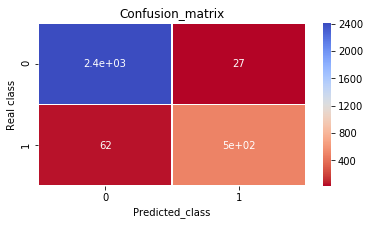


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2440
           1       0.95      0.89      0.92       560

   micro avg       0.97      0.97      0.97      3000
   macro avg       0.96      0.94      0.95      3000
weighted avg       0.97      0.97      0.97      3000



In [206]:
rf= RandomForestClassifier(n_estimators=150,max_depth=50,criterion='gini')
# train data using oversampled data and predict for the test data
no_os_predict_y,no_rf_predict_y=model(rf,data_train_X,data_test_X,data_train_y,data_test_y)


TP: 530
TN: 2355
FP: 85
FN: 30
Cost loss: $ 23500


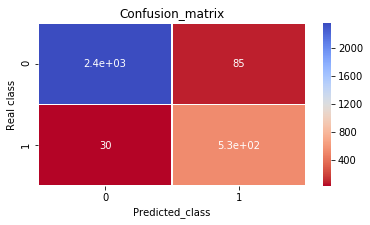


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2440
           1       0.86      0.95      0.90       560

   micro avg       0.96      0.96      0.96      3000
   macro avg       0.92      0.96      0.94      3000
weighted avg       0.96      0.96      0.96      3000



In [207]:
rf_os= RandomForestClassifier(n_estimators=100,max_depth=50,criterion='entropy')
# train data using oversampled data and predict for the test data
predict_y,rf_predict_y=model(rf_os,os_data_X,data_test_X,os_data_y,data_test_y)


Based on cufusion matrix, there are 95 misclassified customers in the model without sampling, and 144 customers are misclassified in the model with sampling. And after comparing f1-score, it looks like that the performance in the first model is slightly better than the second one. However, based on cost loss function, the second model only "waste" \$23500, which is less than \$33700 from first one.

Therefore, I would recommend the second model, the dataset with sampling.


In [192]:
pd.DataFrame(rf.feature_importances_,index = os_data_X.columns, columns=['importance']).sort_values('importance', ascending=False)

,importance
2018-Summer-count,0.174132
2018-Summer-amount,0.141891
2018-Spring-count,0.109313
2018-Spring-amount,0.093248
2019-Spring-count,0.054264
2019-Spring-amount,0.051868
2018-Winter-count,0.051226
2018-Fall-count,0.047496
2017-Fall-count,0.045852
2018-Winter-amount,0.045671


Based on feature importance, 2018 summer and spring are most important factors to influence customer behavior. In contrast, 2017 summer and winter are least important factors, the potential reason for 2017 summer is it only last 1 month in the dataset, transaction activity might be more active in June and July than Augest.

# Summary

In order to extend our research, I assume the dataset is from credit card record. Then we can define "churn" in credit card industry that customer don't use their account over 12 months. And because the transaction of credit card is highly influenced by seasonallity, we seperate two features, count and amount, to spring, summer, fall, and winter in eacch year.

Regarding the ratio of churn and normal, it has slightly imbalanced issue. Therefore, in order to make sure whether it is necessary to do sampling-SMOTE or not, we will evaluate two performance between data with sampling and data without sampling.

In data modeling, I choose Random Forest as my model( providing feature importance and handling unbalance data). Regarding the metric, we use F1-score also define another metric cost loss function, which is calculated the cost from false positive and false negative.    

In model evaluation, although f1-score from the model with sampling is slightly worse than the model without sampling. However, based on cost loss function, the cost loss from the model wtih sampling is less \$10,000 than the model without sampling. Therefore, the model with sampling can be the best model to predict churn problem.


##  Future Work

In [208]:
test_data=data_combine.loc[data_test_y.index,:]
test_data['predict_label'] = predict_y.tolist()
test_data=test_data.join(df_account.loc[data_test_y.index,:])
FN_df=test_data.loc[(test_data['label']!=test_data['predict_label'])&(test_data['label']==1),]

In [217]:
FN_df

,2017-Summer-amount,2017-Summer-count,2017-Fall-amount,2017-Fall-count,2017-Winter-amount,2017-Winter-count,2018-Spring-amount,2018-Spring-count,2018-Summer-amount,2018-Summer-count,2018-Fall-amount,2018-Fall-count,2018-Winter-amount,2018-Winter-count,2019-Spring-amount,2019-Spring-count,label,predict_label,account
9030,2363.418956,640.0,1085.906576,416.000000,1853.437476,357.333333,1683.181006,437.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1,0,e824a0184e81be073e0eaa5bca874d8a
7625,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,271.683833,80.000000,1053.351846,285.000000,1281.231543,290.000000,1232.448589,315.0,1,0,c6d9cd87113e6f7da2f58bb50ecfe3f8
1343,5127.333713,2180.0,143.884151,86.666667,2147.404845,666.666667,13811.969673,4573.333333,6576.281701,2100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1,0,21532345e8aef75c2564278c96f14a3c
2437,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1117.857834,498.666667,463.196082,249.333333,785.727090,322.666667,0.000000,0.000000,0.000000,0.0,1,0,3e24bfda7b4c6e7670a4456e7bb8f564
3858,0.000000,0.0,700.667709,240.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,595.595248,240.000000,3214.253991,345.000000,1180.984443,390.0,1,0,63789cb305e08414b1ab16d88dc39054
7149,3923.795819,1394.0,6115.137633,855.666667,1568.325126,283.333333,9137.057706,1609.333333,0.000000,0.000000,0.000000,0.000000,9.082986,5.666667,0.000000,0.0,1,0,b9e69d140a644c7e62bcb1138402eefd
2767,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7188.465565,490.000000,5983.446203,1176.000000,20686.760729,1414.000000,5512.198195,1106.0,1,0,468249cec333116d47b60cffdc7d6b37
947,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1024.558843,110.000000,5962.856253,775.000000,4641.465776,810.000000,2534.800771,450.0,1,0,17e6d668815a7684f25b9de62f1a5606
3921,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,342.996093,240.000000,765.518579,646.666667,853.286968,380.000000,167.946484,160.0,1,0,651ad5590aeb8823ba2630d6a279dcf1
9174,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,575.220436,106.666667,2611.127945,620.000000,975.397859,446.666667,577.132218,100.0,1,0,ebea136cab00019532b30acac1c5130b


In [219]:
len(FN_df.loc[(FN_df['2017-Summer-count']==0)&(FN_df['2017-Fall-count']==0)&(FN_df['2017-Winter-count']==0)&(FN_df['2018-Spring-count']==0),])

16

Based on the customer information in false positive shown above, the main customer behavior (it accounts for over 50%) is that the model doesn't learn well when they didn't do any transaction from 2017 summer to 2018 spring but did a lot after 2018 summer. The potential reason is the credit card from customer has different bonus categories in different quarters. Therefore, customer might not be interested in these categories from 2017 to 2018 spring.
It would be better for training the model in the future if we can know what kind of credit card in each transaction.